# Setup

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_excel('combined.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   1558 non-null   object 
 1   city                          1558 non-null   object 
 2   state                         1558 non-null   object 
 3   zipcode                       1558 non-null   int64  
 4   latitude                      1558 non-null   float64
 5   longitude                     1558 non-null   float64
 6   urban_classification          1558 non-null   object 
 7   bedrooms                      1558 non-null   int64  
 8   bathrooms                     1558 non-null   float64
 9   total_sqft                    1558 non-null   float64
 10  parking_spaces                1558 non-null   float64
 11  building_type                 1558 non-null   object 
 12  building_age                  1558 non-null   int64  
 13  las

# Data Cleaning

In [102]:
columns_to_drop = ['total_monthly_revenue', 'annual_revenue', 'revenue_per_sqft', 'nearest_university', 'nearest_tech_hub', 'property_id', 'state', 'zipcode']
df = df.drop(columns=columns_to_drop)
df['coworking_space'] = df['coworking_space'].fillna('None')
df['smart_home_level'] = df['smart_home_level'].fillna('None')

In [103]:
df['age_since_renovation'] = df['building_age'] - df['last_renovation']
df['total_property_sqft'] = df['total_sqft'] + df['common_area_sqft'] # Create the new combined feature
df = df.drop(columns=['building_age', 'last_renovation', 'total_sqft', 'common_area_sqft']) # Drop original and redundant columns
display(df.head())

,city,latitude,longitude,urban_classification,bedrooms,bathrooms,parking_spaces,building_type,condition_score,coworking_space,...,avg_market_occupancy,property_tax_rate,hoa_fee_monthly,short_term_rental_restricted,rent_controlled,monthly_revenue_per_bedroom,occupancy_rate,property_tier,age_since_renovation,total_property_sqft
0,New York,40.7128,-74.0060,mixed,3,1.5,0.5,condo,81.0,Basic,...,0.850,0.0171,0.00,True,False,3869.67,0.7359,Premium,26,2025.6
1,San Francisco,37.7749,-122.4194,urban,5,3.0,1.0,house,90.3,Premium,...,0.866,0.0062,38.16,True,False,2825.56,0.9800,Premium,3,2919.4
2,Los Angeles,34.0522,-118.2437,urban,5,3.0,0.5,apartment,88.5,Basic,...,0.817,0.0051,0.00,True,False,2719.16,0.7883,Standard,0,3429.0
3,New York,40.7128,-74.0060,suburban,4,1.5,1.0,apartment,76.8,None,...,0.877,0.0170,0.00,True,True,1274.58,0.8988,Budget,0,2238.0
4,New York,40.7128,-74.0060,mixed,4,2.5,1.0,house,83.1,Premium,...,0.852,0.0170,0.00,False,False,3652.19,0.8479,Premium,14,2256.2


In [104]:
bool_cols = ['gym', 'pool', 'pet_friendly', 'ev_charging', 'outdoor_space', 'bike_storage', 'furnished', 'utilities_included', 'short_term_rental_restricted', 'rent_controlled']
for col in bool_cols:
    df[col] = df[col].astype(int)

df['coworking_space_binary'] = df['coworking_space'].apply(lambda x: 0 if x == 'None' else 1)
df['laundry_binary'] = df['laundry'].apply(lambda x: 0 if x == 'None' else 1)


amenity_cols = bool_cols + ['coworking_space_binary', 'laundry_binary']
df['amenity_score'] = df[amenity_cols].sum(axis=1)

cols_to_drop_after_amenity = ['coworking_space', 'laundry'] + amenity_cols
df = df.drop(columns=cols_to_drop_after_amenity)

display(df.head())

,city,latitude,longitude,urban_classification,bedrooms,bathrooms,parking_spaces,building_type,condition_score,smart_home_level,...,market_maturity_years,avg_market_occupancy,property_tax_rate,hoa_fee_monthly,monthly_revenue_per_bedroom,occupancy_rate,property_tier,age_since_renovation,total_property_sqft,amenity_score
0,New York,40.7128,-74.0060,mixed,3,1.5,0.5,condo,81.0,Premium,...,10.2,0.850,0.0171,0.00,3869.67,0.7359,Premium,26,2025.6,6
1,San Francisco,37.7749,-122.4194,urban,5,3.0,1.0,house,90.3,Basic,...,9.9,0.866,0.0062,38.16,2825.56,0.9800,Premium,3,2919.4,9
2,Los Angeles,34.0522,-118.2437,urban,5,3.0,0.5,apartment,88.5,Basic,...,6.5,0.817,0.0051,0.00,2719.16,0.7883,Standard,0,3429.0,7
3,New York,40.7128,-74.0060,suburban,4,1.5,1.0,apartment,76.8,Premium,...,8.5,0.877,0.0170,0.00,1274.58,0.8988,Budget,0,2238.0,5
4,New York,40.7128,-74.0060,mixed,4,2.5,1.0,house,83.1,Premium,...,10.6,0.852,0.0170,0.00,3652.19,0.8479,Premium,14,2256.2,4


In [105]:
categorical_cols = df.select_dtypes(include='object').columns

df = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)

display(df.head())

,latitude,longitude,bedrooms,bathrooms,parking_spaces,condition_score,walk_score,transit_score,bike_score,distance_university,...,building_type_apartment,building_type_condo,building_type_house,building_type_townhouse,smart_home_level_Basic,smart_home_level_None,smart_home_level_Premium,property_tier_Budget,property_tier_Premium,property_tier_Standard
0,40.7128,-74.0060,3,1.5,0.5,81.0,72.4,78.8,60.8,1.94,...,False,True,False,False,False,False,True,False,True,False
1,37.7749,-122.4194,5,3.0,1.0,90.3,55.1,58.9,48.5,5.49,...,False,False,True,False,True,False,False,False,True,False
2,34.0522,-118.2437,5,3.0,0.5,88.5,60.9,49.9,60.3,7.88,...,True,False,False,False,True,False,False,False,False,True
3,40.7128,-74.0060,4,1.5,1.0,76.8,51.1,42.2,38.2,8.60,...,True,False,False,False,False,False,True,True,False,False
4,40.7128,-74.0060,4,2.5,1.0,83.1,60.1,63.4,57.0,5.43,...,False,False,True,False,False,False,True,False,True,False


In [106]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
display(df_scaled.head())

,latitude,longitude,bedrooms,bathrooms,parking_spaces,condition_score,walk_score,transit_score,bike_score,distance_university,...,building_type_apartment,building_type_condo,building_type_house,building_type_townhouse,smart_home_level_Basic,smart_home_level_None,smart_home_level_Premium,property_tier_Budget,property_tier_Premium,property_tier_Standard
0,0.342428,1.294712,-0.989441,-0.878204,-1.015525,-0.131657,1.402784,2.736638,0.455495,-0.371150,...,-0.855050,2.159966,-0.651254,-0.33948,-0.900904,-0.565985,1.494110,-0.206973,1.139270,-1.048680
1,-0.101546,-1.106351,0.868967,1.420074,0.984712,0.946467,-0.972188,0.139538,-1.040063,0.725382,...,-0.855050,-0.462970,1.535499,-0.33948,1.109996,-0.565985,-0.669295,-0.206973,1.139270,-1.048680
2,-0.664119,-0.899257,0.868967,1.420074,-1.015525,0.737798,-0.175955,-1.035030,0.394699,1.463610,...,1.169522,-0.462970,-0.651254,-0.33948,1.109996,-0.565985,-0.669295,-0.206973,-0.877755,0.953579
3,0.342428,1.294712,-0.060237,-0.878204,0.984712,-0.618552,-1.521315,-2.039938,-2.292441,1.686005,...,1.169522,-0.462970,-0.651254,-0.33948,-0.900904,-0.565985,1.494110,4.831537,-0.877755,-1.048680
4,0.342428,1.294712,-0.060237,0.653982,0.984712,0.111790,-0.285780,0.726821,-0.006548,0.706849,...,-0.855050,-0.462970,1.535499,-0.33948,-0.900904,-0.565985,1.494110,-0.206973,1.139270,-1.048680


# Modeling

## Lasso

In [107]:
X = df_scaled.drop('monthly_revenue_per_bedroom', axis=1)
y = df_scaled['monthly_revenue_per_bedroom']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [108]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
print(f"Best alpha for Lasso: {best_alpha_lasso:.4f}")

ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.best_params_['alpha']
print(f"Best alpha for Ridge: {best_alpha_ridge:.4f}")

param_grid_elastic = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                      'l1_ratio': [0.1, 0.5, 0.9]}

elastic_cv = GridSearchCV(ElasticNet(), param_grid_elastic, cv=5)
elastic_cv.fit(X_train, y_train)
best_params_elastic = elastic_cv.best_params_
print(f"Best parameters for ElasticNet: {best_params_elastic}")

Best alpha for Lasso: 0.0100
Best alpha for Ridge: 10.0000


c:\Users\elish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+00, tolerance: 1.008e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\elish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e+00, tolerance: 9.587e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\elish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Best parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.5}


In [109]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [110]:
y_pred = lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.2466
Root Mean Squared Error (RMSE): 0.4966
R-squared (R2): 0.7574


## Ridge

In [111]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

,alpha,10
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [112]:
y_pred_ridge = ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Model - Mean Squared Error (MSE): {mse_ridge:.4f}")
print(f"Ridge Model - Root Mean Squared Error (RMSE): {rmse_ridge:.4f}")
print(f"Ridge Model - R-squared (R2): {r2_ridge:.4f}")

Ridge Model - Mean Squared Error (MSE): 0.2469
Ridge Model - Root Mean Squared Error (RMSE): 0.4969
Ridge Model - R-squared (R2): 0.7571


## Linear Regression

In [113]:
linear = LinearRegression()
linear.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [114]:
y_pred_linear = linear.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression Model - Mean Squared Error (MSE): {mse_linear:.4f}")
print(f"Linear Regression Model - Root Mean Squared Error (RMSE): {rmse_linear:.4f}")
print(f"Linear Regression Model - R-squared (R2): {r2_linear:.4f}")

Linear Regression Model - Mean Squared Error (MSE): 0.2473
Linear Regression Model - Root Mean Squared Error (RMSE): 0.4973
Linear Regression Model - R-squared (R2): 0.7567


## Elastic Net

In [115]:
elastic = ElasticNet(alpha=0.01, l1_ratio=0.5)
elastic.fit(X_train, y_train)
elastic.score(X_test, y_test)

0.7579115115761916

# Implications and Coefficients

In [116]:
print("Linear Regression Model Coefficients:")
coef_df = pd.DataFrame({'feature': X.columns, 'coefficient': linear.coef_})

top_positive_coef = coef_df.sort_values(by='coefficient', ascending=False).head(10)
top_negative_coef = coef_df.sort_values(by='coefficient', ascending=True).head(10)

print("\nTop 10 Positive Coefficients:")
display(top_positive_coef)

print("\nTop 10 Negative Coefficients:")
display(top_negative_coef)

Linear Regression Model Coefficients:

Top 10 Positive Coefficients:


,feature,coefficient
57,property_tier_Premium,0.287702
38,city_Chicago,0.211142
42,city_New York,0.174747
40,city_Los Angeles,0.165308
44,city_San Francisco,0.146613
5,condition_score,0.080330
35,amenity_score,0.078557
19,median_income_zipcode,0.065848
7,transit_score,0.055186
6,walk_score,0.045953



Top 10 Negative Coefficients:


,feature,coefficient
58,property_tier_Standard,-0.205911
56,property_tier_Budget,-0.200519
39,city_Denver,-0.136696
41,city_Miami,-0.118220
43,city_Portland,-0.114140
45,city_Seattle,-0.113514
37,city_Boston,-0.107182
36,city_Austin,-0.092937
11,distance_downtown,-0.052859
24,population_density,-0.042837


“I hypothesize that property characteristics such as price, location type, and number of amenities significantly influence occupancy rate. Properties with lower prices and more amenities are more likely to be high-performing (occupancy ≥ 85%).”

c:\Users\elish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\elish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\elish\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



=== Model Comparison ===
                     Accuracy      F1     AUC
Logistic Regression    0.7735  0.8285  0.8343
KNN                    0.6645  0.7688  0.6801
Decision Tree          0.7500  0.8116  0.7790

Best Model: Logistic Regression

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67       168
           1       0.81      0.85      0.83       300

    accuracy                           0.77       468
   macro avg       0.76      0.74      0.75       468
weighted avg       0.77      0.77      0.77       468



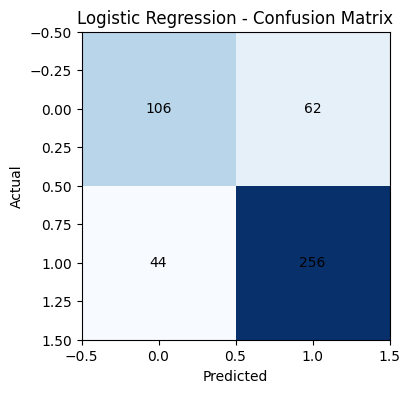

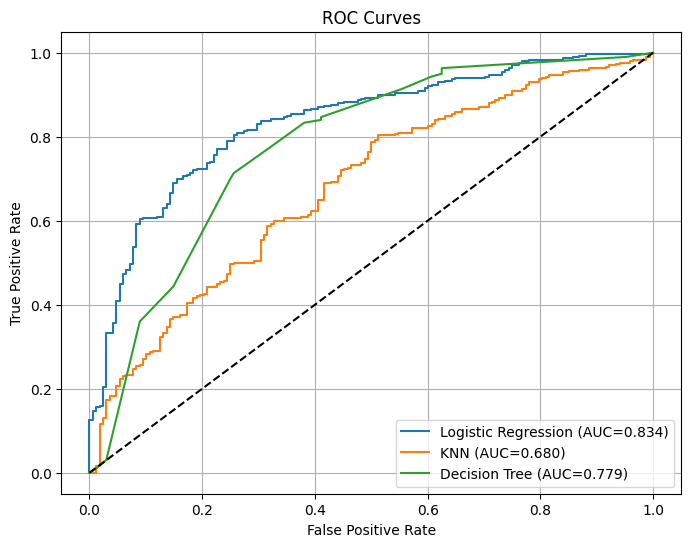

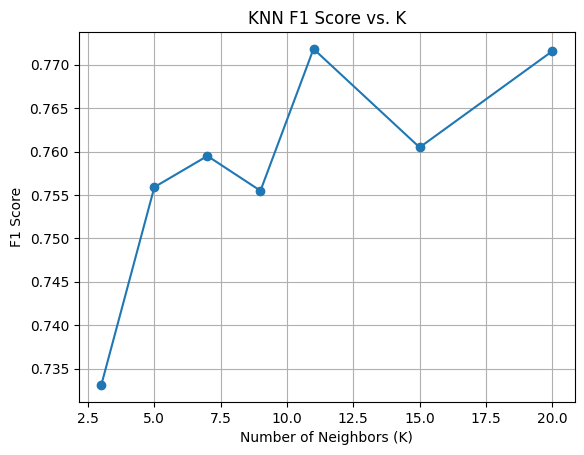

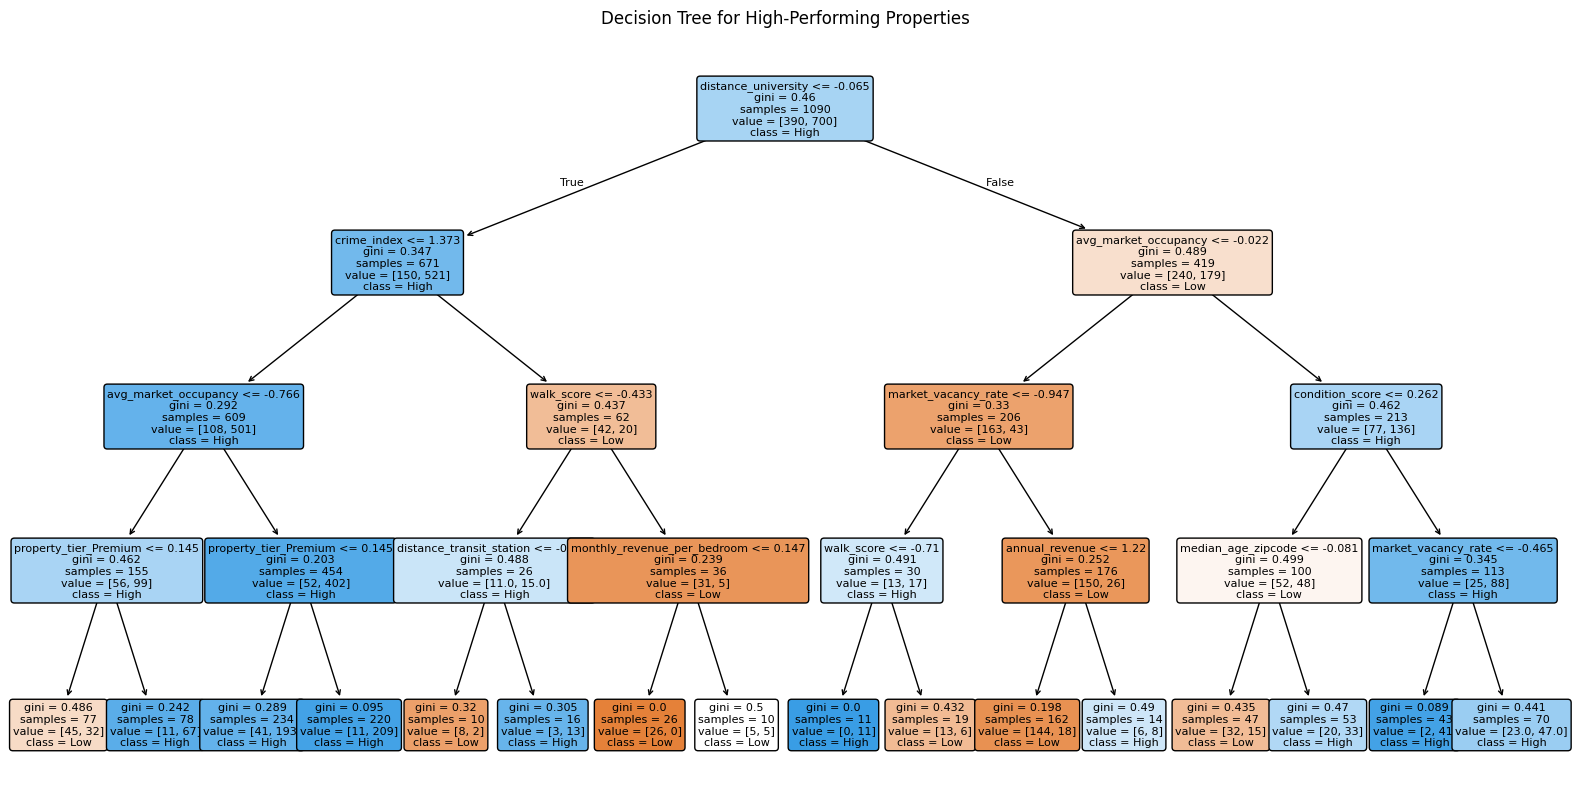


Top Predictors for High Occupancy:
distance_university         0.291424
avg_market_occupancy        0.244329
crime_index                 0.130352
property_tier_Premium       0.087031
market_vacancy_rate         0.061300
walk_score                  0.057043
condition_score             0.043863
annual_revenue              0.025293
distance_transit_station    0.021385
median_age_zipcode          0.021253
dtype: float64


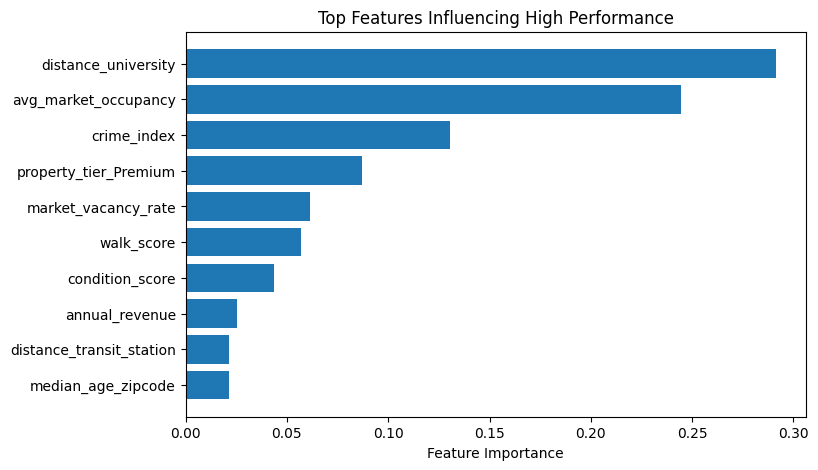


===== Summary Insights =====
Best Model: Logistic Regression
Top 3 Predictors:
distance_university     0.291424
avg_market_occupancy    0.244329
crime_index             0.130352
dtype: float64

Interpretation: These features most strongly distinguish high-performing (≥0.85 occupancy) properties. Focus business improvements or marketing strategies on these variables.


In [127]:
# =======================
# 1. Import Libraries
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

# =======================
# 2. Load & Prepare Data
# =======================
df = pd.read_excel("combined.xlsx")# Replace with your file

# Create binary target variable
df['high_performer'] = (df['occupancy_rate'] >= 0.85).astype(int)

# Drop unnecessary columns
X = df.drop(columns=['occupancy_rate', 'high_performer', 'property_id'], errors='ignore')
y = df['high_performer']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# =======================
# 3. Split & Scale
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# =======================
# 4. Logistic Regression (Grid Search)
# =======================
# Logistic Regression GridSearch - FIXED VERSION
logreg = LogisticRegression(max_iter=1000, random_state=42)

param_log = {
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l2']
}

# Ensure no missing or infinite values
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

grid_log = GridSearchCV(logreg, param_log, scoring='f1', cv=3, n_jobs=-1)
grid_log.fit(X_train, y_train)


# =======================
# 5. KNN (Grid Search)
# =======================
knn = KNeighborsClassifier()
param_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_knn = GridSearchCV(knn, param_knn, scoring='f1', cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)

# =======================
# 6. Decision Tree (Grid Search)
# =======================
tree = DecisionTreeClassifier(random_state=42)
param_tree = {
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 3, 5, 10]
}
grid_tree = GridSearchCV(tree, param_tree, scoring='f1', cv=5, n_jobs=-1)
grid_tree.fit(X_train, y_train)

# =======================
# 7. Evaluate All Models
# =======================
best_models = {
    "Logistic Regression": grid_log.best_estimator_,
    "KNN": grid_knn.best_estimator_,
    "Decision Tree": grid_tree.best_estimator_
}

results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    }

results_df = pd.DataFrame(results).T.round(4)
print("\n=== Model Comparison ===")
print(results_df)

# =======================
# 8. Best Model & Confusion Matrix
# =======================
best_name = results_df['F1'].idxmax()
best_model = best_models[best_name]
print(f"\nBest Model: {best_name}")
y_pred_best = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title(f'{best_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()

# =======================
# 9. ROC Curves
# =======================
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# =======================
# 10. KNN F1 vs. K Plot
# =======================
k_values = [3, 5, 7, 9, 11, 15, 20]
f1_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    f1_scores.append(f1_score(y_test, knn.predict(X_test)))

plt.figure()
plt.plot(k_values, f1_scores, marker='o')
plt.title('KNN F1 Score vs. K')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

# =======================
# 11. Decision Tree Visualization
# =======================
best_tree = grid_tree.best_estimator_
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=X.columns,
    class_names=['Low', 'High'],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for High-Performing Properties")
plt.show()

# =======================
# 12. Feature Importance
# =======================
importances = pd.Series(best_tree.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False).head(10)
print("\nTop Predictors for High Occupancy:")
print(importances)

plt.figure(figsize=(8, 5))
plt.barh(importances.index, importances.values)
plt.title('Top Features Influencing High Performance')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# =======================
# 13. Quick Summary
# =======================
print("\n===== Summary Insights =====")
print(f"Best Model: {best_name}")
print("Top 3 Predictors:")
print(importances.head(3))
print("\nInterpretation: These features most strongly distinguish high-performing (≥0.85 occupancy) properties. Focus business improvements or marketing strategies on these variables.")
